In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from scipy.optimize import minimize, rosen, rosen_der
np.set_printoptions(precision=3)
import pandas as P
P.set_option('display.precision',3)

In [2]:
NL_t = 0.6
NL_c = 0.01
NL_L = 1.8
NL_mu = 0.3

mass = 938.272045e6
ke = 2.5*1.0e6
energy = ke+mass
freq = 30*1.0e6

g = energy/mass
bg = np.sqrt(g**2-1.0)
vec = bg/g*impact.data.clight

alfaEntrance = np.tan(np.pi*NL_mu)
betaEntrance = NL_L/np.sin(2.0*np.pi*NL_mu)

In [3]:
print(alfaEntrance,betaEntrance)

1.3763819204711734 1.8926320036288808


# def subroutine 

In [4]:
def croot(z):
    return np.sqrt(1.0-z**2)

def carcsin(z):
    return -1j*np.log(1j*z+croot(z))

def Fpotential(x,y):
    zeta = x+1j*y
    return zeta/croot(zeta)*carcsin(zeta)

def Fderivative(x,y):
    zeta = x+1j*y
    denom = croot(zeta)
    return zeta/denom**2 + carcsin(zeta)/denom**3

def driftpropagator(x,px,y,py,ds):
    x= x+px*ds
    y= y+py*ds
    return x,px,y,py

def NLpropagator(x,px,y,py,ds):
    dF = Fderivative(x,y)
    px = px - x*ds + np.real(dF)*ds*NL_t
    if y==0.0:
        py = py - y*ds
    else:
        py = py - y*ds - np.imag(dF)*ds*NL_t
    return x,px,y,py


def InvariantPotentials(x,px,y,py):
    zeta = x+1j*y
    zetaconj = x-1j*y
    Hpotential = zeta/croot(zeta)
    Ipotential = (zeta+zetaconj)/croot(zeta)   
    Hpotential = Hpotential*carcsin(zeta)
    Ipotential = Ipotential*carcsin(zeta)
    Hinv = -NL_t*np.real(Hpotential) + 0.5*(x**2+px**2+y**2+py**2)
    Iinv = -NL_t*np.real(Ipotential) + (x*py - y*px)**2 + x**2 + px**2
    return Hinv,Iinv

  
def track(x,px,y,py,L,nSteps,mSample):
    n = int(nSteps)
    n_hidden = int(n/mSample)
    ds = L/n
    data = np.zeros((6,mSample+1))
    k=0
    for i in range(n):
        if k==mSample+1:
            break
        if np.mod(i,n_hidden)==0:
            data[:4,k] = x,px,y,py
            data[4:,k] = InvariantPotentials(x,px,y,py)
            k=k+1
        x,px,y,py = driftpropagator(x,px,y,py,0.5*ds)
        x,px,y,py = NLpropagator(x,px,y,py,ds)
        x,px,y,py = driftpropagator(x,px,y,py,0.5*ds)
    data[:4,-1] = x,px,y,py
    data[4:,-1] = InvariantPotentials(x,px,y,py)
    return data

In [5]:
pdata0 = np.loadtxt('initP.tau=0.6.txt')

In [6]:
pdata0.shape

(15, 4)

In [7]:
Lrad = 1024*4
data = track(0, 0.2818434260011062, 0, 0.722421779980452, Lrad,1024*256*4,1024*256*4)

In [8]:
poincare = []
for i in range(1024*64):
    if data[2,i]**2 < 0.000001:
        poincare.append([data[0,i],data[1,i]])
poincare = np.array(poincare)

In [9]:
poincare.shape

(84, 2)

Text(0,0.5,'py')

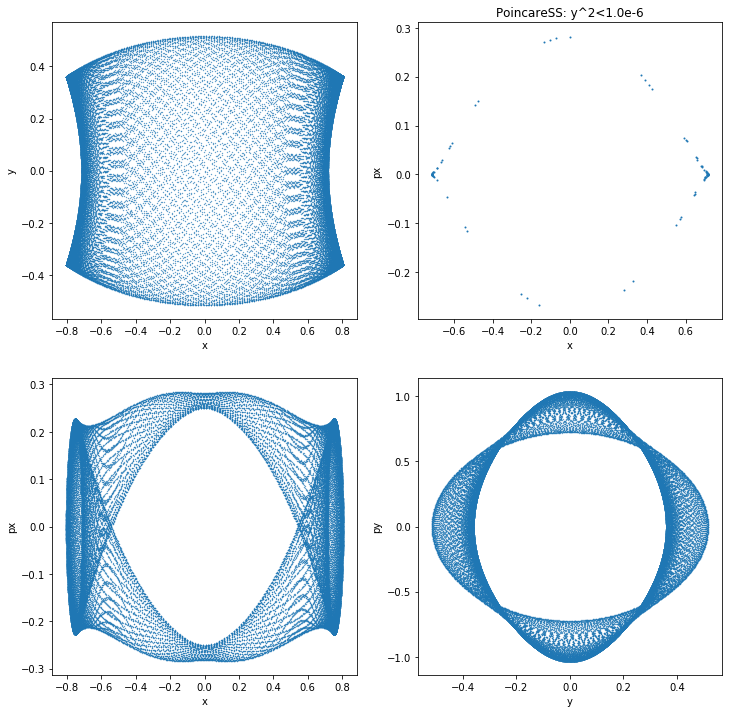

In [10]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.scatter(data[0,::16],data[2,::16],s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(2,2,2)
plt.scatter(poincare[:,0],poincare[:,1],s=1.0)
plt.title('PoincareSS: y^2<1.0e-6');
plt.xlabel('x')
plt.ylabel('px')
plt.subplot(2,2,3)
plt.scatter(data[0,::16],data[1,::16],s=0.1)
plt.xlabel('x')
plt.ylabel('px')
plt.subplot(2,2,4)
plt.scatter(data[2,::16],data[3,::16],s=0.1)
plt.xlabel('y')
plt.ylabel('py')